In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, sys
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import init
jaxm = init(device="cuda", dtype="float")
#jaxm = init(device="cpu", dtype="float")

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn
import jaxopt
from pmpc.experimental import scp_solve
from pmpc.experimental.convex_solver import ConvexSolver
print(jaxm.zeros(()).dtype)
print(jaxm.zeros(()).device())

float32
gpu:0


In [3]:
P, q = jaxm.randn((100, 100)), jaxm.randn((100,))
P = P @ P.T

def obj_fn(x):
    J = jaxm.sum(x * (P @ x)) / 2 + jaxm.sum(q * x) + jaxm.sum(-jaxm.log(x))
    J = jaxm.where(jaxm.any(x < 0.0), jaxm.inf, J)
    return J
#print(f"best_loss = {obj_fn(jaxm.linalg.solve(P, -q))}")

In [4]:
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="binary_search", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")
print()
solver = ConvexSolver(obj_fn, jit=True, maxiter=100, tol=1e-3, linesearch="scan", maxls=20)
params = jaxm.ones((100,))
state = solver.init_state(params)
for it in range(10):
    params, state = solver.update(params, state)
    print(f"{jaxm.norm(params), state.best_loss}")

(Array(8.275746, dtype=float32), Array(2043.1615, dtype=float32))
(Array(5.5081177, dtype=float32), Array(629.70386, dtype=float32))
(Array(3.6151588, dtype=float32), Array(303.9194, dtype=float32))
(Array(2.484094, dtype=float32), Array(218.64713, dtype=float32))
(Array(2.5297148, dtype=float32), Array(217.7071, dtype=float32))
(Array(2.5315647, dtype=float32), Array(217.67392, dtype=float32))
(Array(2.5310357, dtype=float32), Array(217.67326, dtype=float32))
(Array(2.5310104, dtype=float32), Array(217.67325, dtype=float32))
(Array(2.5310104, dtype=float32), Array(217.67325, dtype=float32))
(Array(2.5310104, dtype=float32), Array(217.67325, dtype=float32))

(Array(8.037047, dtype=float32), Array(1846.2959, dtype=float32))
(Array(6.389944, dtype=float32), Array(1008.79065, dtype=float32))
(Array(5.113292, dtype=float32), Array(597.41614, dtype=float32))
(Array(4.2093873, dtype=float32), Array(397.80444, dtype=float32))
(Array(3.6067312, dtype=float32), Array(302.4321, dtype=float32))
(

In [5]:
def f_fx_fu_fn(X_prev, U_prev):
    X_prev, U_prev = np.array(X_prev), np.array(U_prev)
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return f_fn(x, u, p), fx_fn(x, u, p), fu_fn(x, u, p)

In [6]:
M, N, xdim, udim = 400, 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u = [
    np.tile(z, (M,) + (1,) * z.ndim) for z in [Q, R, x0, X_ref, U_ref, X_prev, U_prev, u_l, u_u]
]

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=3e0, reg_u=1e0)
args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)

In [7]:
X, U, data = scp_solve(
    *args, max_it=50, res_tol=1e-12, **opts, solver_settings=dict(smooth_alpha=1e2, solver="CVX")
)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  3.712e+00 |  4.743e+01 |  1.541e+00 |  3.0e+00 |  1.0e+00 |  1.0e-01 |
| 0002 |  3.970e+00 |  2.818e-01 |  4.657e-01 |  3.0e+00 |  1.0e+00 |  1.0e+00 |
| 0003 |  4.157e+00 |  3.590e+00 |  2.416e+00 |  3.0e+00 |  1.0e+00 |  1.0e+01 |
| 0004 |  4.337e+00 |  9.597e-01 |  6.359e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  4.520e+00 |  8.013e-01 |  2.453e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0006 |  4.704e+00 |  7.700e-01 |  1.019e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0007 |  4.889e+00 |  7.557e-01 |  1.252e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0008 |  5.077e+00 |  7.470e-01 |  1.167e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0009 |  5.260e+00 |  7.416e-01 |  1.030e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0010 |  5.443e+00 |  7.380

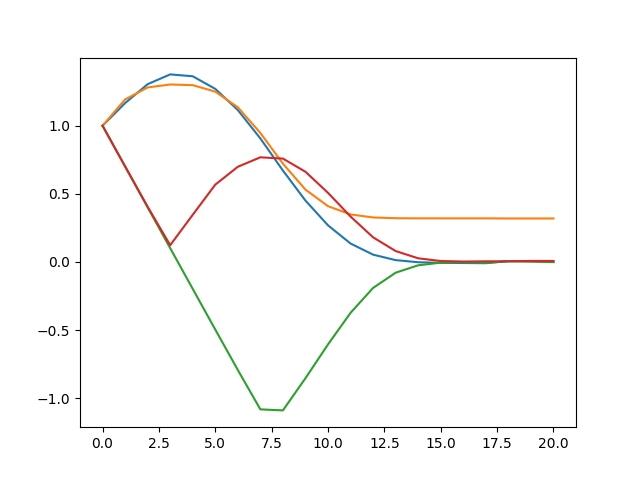

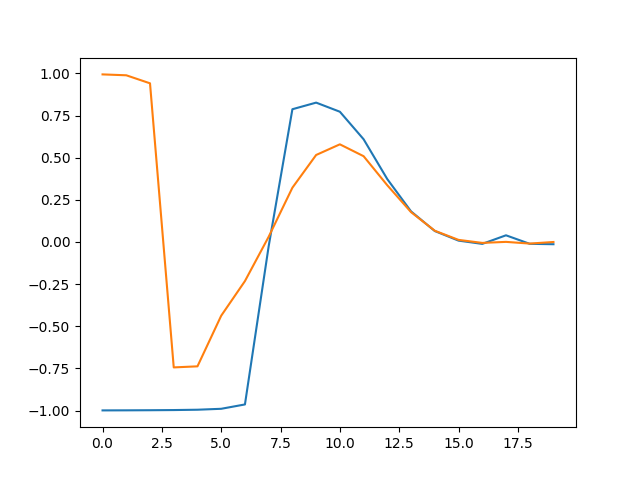

In [25]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[idx, :, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[idx, :, r], label=f"u{r}")
plt.show()

In [21]:
opts["solver_settings"] = dict(solver="ecos", smooth_alpha=1e2, smooth_cstr="logbarrier")
X2, U2, data = pmpc.solve(
    *[arg[0] if hasattr(arg, "shape") else arg for arg in args], max_it=50, **opts
)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  1.019e-02 |  2.209e+00 |  1.945e+00 |  3.000e+00 |  1.000e+00 |
| 0002 |  1.875e-02 |  2.008e+00 |  3.074e-01 |  3.000e+00 |  1.000e+00 |
| 0003 |  2.615e-02 |  1.865e+00 |  2.038e-01 |  3.000e+00 |  1.000e+00 |
| 0004 |  3.352e-02 |  1.773e+00 |  1.288e-01 |  3.000e+00 |  1.000e+00 |
| 0005 |  4.068e-02 |  1.720e+00 |  1.474e-01 |  3.000e+00 |  1.000e+00 |
| 0006 |  4.782e-02 |  1.687e+00 |  1.428e-01 |  3.000e+00 |  1.000e+00 |
| 0007 |  5.495e-02 |  1.667e+00 |  1.284e-01 |  3.000e+00 |  1.000e+00 |
| 0008 |  6.207e-02 |  1.653e+00 |  1.116e-01 |  3.000e+00 |  1.000e+00 |
| 0009 |  6.932e-02 |  1.644e+00 |  9.363e-02 |  3.000e+00 |  1.000e+00 |
| 0010 |  7.633e-02 |  1.638e+00 |  7.423e-02 |  3.000e+00 |  1.000e+00 |
| 0011 |  8.332e-02 |  1.634e+00 |  5.

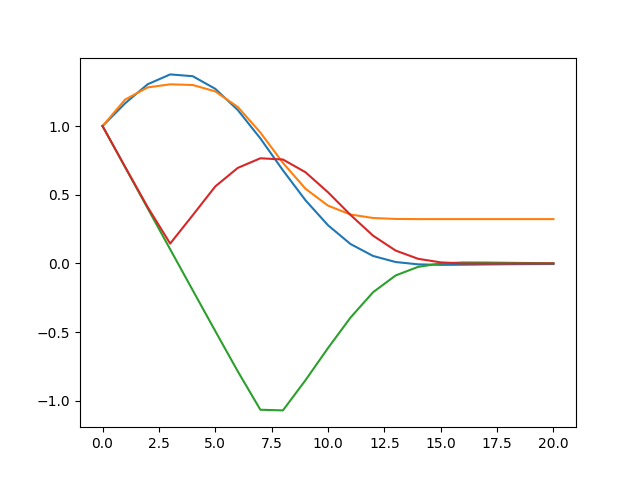

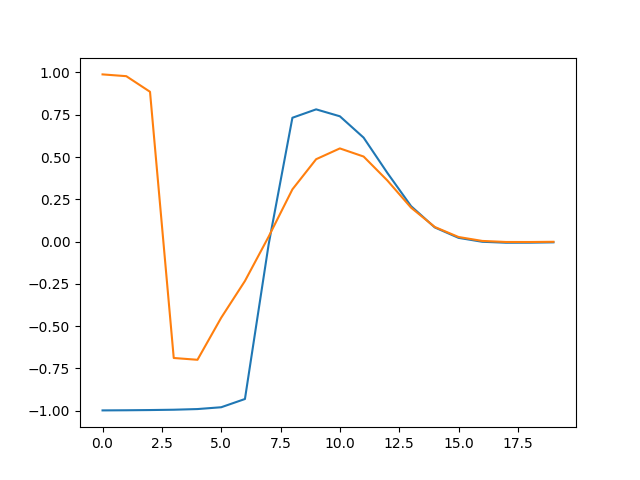

In [24]:
plt.figure(663454475)
plt.clf()
for r in range(X2.shape[1]):
    plt.plot(X2[:, r], label=f"x{r}")
plt.show()
plt.figure(45435534)
plt.clf()
for r in range(U2.shape[1]):
    plt.plot(U2[:, r], label=f"u{r}")
plt.show()